In [3]:
import pandas as pd 
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from pyproj import datadir

datadir.set_data_dir("/home/jupyter-daniela/.conda/envs/peru_environment/share/proj")



In [4]:


calas_path = Path("/home/jupyter-daniela/suyana/peru_production/outputs/")

df_calas = pd.read_csv(calas_path / "calas_all_data.csv", low_memory=False)
df_calas['fecha_cala'] = pd.to_datetime(df_calas['fecha_cala'], errors='coerce').dt.tz_localize('America/Lima')

df_calas = df_calas.rename(columns={'latitud ': 'latitud'})


In [5]:
shapefile_peru = Path("/home/jupyter-daniela/suyana/geometries/areas_pesca_peru/areas_pesca_peru.shp")

gdf_peru = gpd.read_file(shapefile_peru)

In [6]:

gdf_calas = gpd.GeoDataFrame(
    df_calas,
    geometry=gpd.points_from_xy(df_calas['longitud'], df_calas['latitud']),
    crs='EPSG:4326'
)
gdf_peru = gdf_peru.to_crs('EPSG:4326')

gdf_join = gpd.sjoin(gdf_calas, gdf_peru[['DPTO', 'geometry']], how='inner', predicate='within')
df_join = pd.DataFrame(gdf_join.drop(columns='geometry'))

<Axes: ylabel='DPTO'>

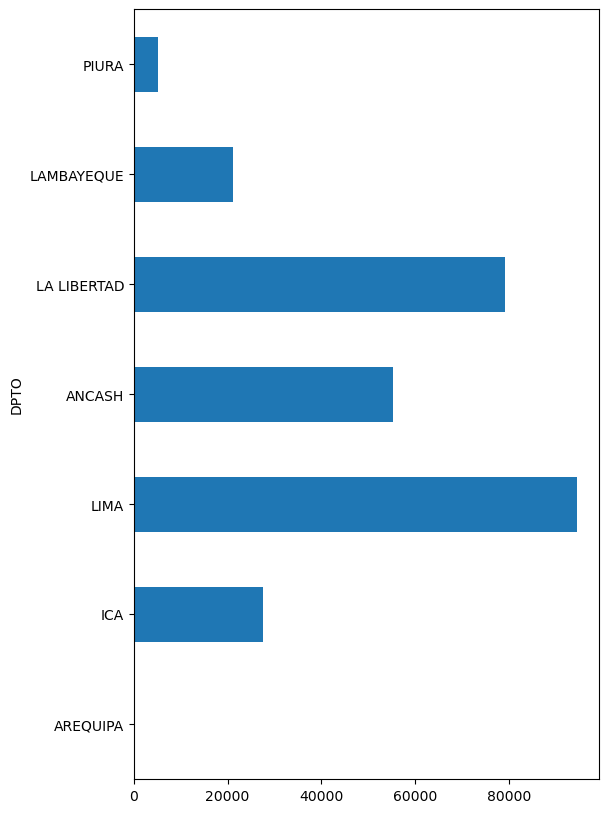

In [24]:
order = ['PIURA', 'LAMBAYEQUE', 'LA LIBERTAD', 'ANCASH', 'LIMA', 'ICA', 'AREQUIPA'][::-1]
df_join['DPTO'].value_counts()[order].plot(kind='barh', figsize=(6,10))


In [10]:

serie_diaria = []
for (region, temporada), df_sub in df_join.groupby(['DPTO', 'temporada']):
    s = (
        df_sub.groupby('fecha_cala')['declarado_tm']
        .sum()
        .rename('total_pescado_tm')
        .reset_index()
        .set_index('fecha_cala')
        .sort_index()
        .asfreq('D')
        .assign(DPTO=region, temporada=temporada)
    )
    serie_diaria.append(s)

serie_diaria = pd.concat(serie_diaria).reset_index()

In [17]:
serie_diaria['DPTO'].value_counts()

DPTO
LA LIBERTAD    1246
LIMA           1204
ANCASH         1201
ICA             978
LAMBAYEQUE      883
PIURA           505
AREQUIPA         16
Name: count, dtype: int64